# Jupyter notebook to see movement induced by Amphan cyclone

### _Follows pyspark notebooks:_
1. _`02 India Weekly Movement OD Matrices`_
2. _`03 India Amphan Cyclone`_
3. _`03 India Amphan Cyclone Daily`_

## Imports

In [28]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gp

import palettable

import plotly.graph_objects as go

## Read district shapefile and weekly CSV files -- net movement, net movement percentage and number of samples

In [29]:
adm2 = gp.read_file('Administrative_Boundaries.gpkg', layer='Admin2')

# nm = pd.read_csv('Results/2020/adm2/Weekly/long_df_nm.csv')
nmp = pd.read_csv('Results/2020/adm2/Weekly/long_df_nmp.csv')
samples = pd.read_csv('Results/2020/adm2/Weekly/long_df_samples.csv')

## Preprocessing

In [30]:
# convert net movement ratios to percentages
nmp['net_mvmt_pct'] = nmp['net_mvmt_pct'] * 100

# convert string formatted date to datetime format and subtract 3.5 days from it for visual correctness of graphs
for df in [nmp, samples]:
    df['Week'] = pd.to_datetime(df['Week'].str.split('_').apply(lambda x: "-".join(x))) - timedelta(days=3.5)
    
# changing district code datatypes to integer
adm2['L2_CODE'] = adm2['L2_CODE'].astype(int)

# appending the state and district names in net movement percentage dataframe
nmp['adm2_name'] = nmp['adm2'].map(dict(zip(adm2['L2_CODE'], adm2['L2_NAME'])))
nmp['adm1_name'] = nmp['adm2'].map(dict(zip(adm2['L2_CODE'], adm2['L1_NAME'])))

## Timeseries plot of cyclone Amphan affected districts and their average

In [31]:
# we take North Twenty Four Parganas, Kolkata, South Twenty Four Parganas and Purba Medinipur as the cyclone Amphan affected districts
affected_districts = pd.Series(
    ['North Twenty Four Parganas', 'Kolkata', 'South Twenty Four Parganas', 'Purba Medinipur']
)

# names and admin codes of the affected districts
ad_map = {
    'North Twenty Four Parganas': 337,
    'Kolkata': 342,
    'South Twenty Four Parganas': 343,
    'Purba Medinipur': 345,
}

# let's only take net movement percentage of those districts, also let's only filter for the month of May and June
ad_df = nmp[(nmp['adm2_name'].isin(affected_districts)) & ('2020-05-01' <= nmp['Week'].dt.date.astype(str)) & ('2020-07-01' >= nmp['Week'].dt.date.astype(str))]

# compute mean metrics of those affected districts 
mean_ad_df = pd.DataFrame(ad_df.groupby(['Week']).mean()['net_mvmt_pct']).reset_index()

traces = []
    
for district, code in ad_map.items():
    df_nmp = ad_df[ad_df['adm2'] == code]
    traces.append(
        go.Scatter(
            opacity=0.15, 
            x=df_nmp['Week'], 
            y=df_nmp['net_mvmt_pct'], 
            name=district,
        )
    )

traces.append(
    go.Scatter(
        opacity=1, 
        x=mean_ad_df['Week'], 
        y=mean_ad_df['net_mvmt_pct'], 
        name='Districts average'
    )
)

traces.extend([
    go.Scatter(
        x=[datetime(2020, 5, 16), datetime(2020, 5, 16)],
        y=[-5, 5],
        line={
            'dash': 'dashdot',
        },
        name='Cyclone Amphan formed',
    ),
    go.Scatter(
        x=[datetime(2020, 5, 21), datetime(2020, 5, 21)],
        y=[-5, 5],
        line={
            'dash': 'dashdot',
        },
        name='Cyclone Amphan dissipated',
    )
])

# Using plotly.express
fig = go.Figure()
fig.add_traces(traces)

fig.update_layout(
    title="",
    xaxis_title="Date",
    yaxis_title="Net movement percentage (%)",
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [32]:
nmp = nmp.merge(samples[['adm2', 'Week', 'total']], on=['Week', 'adm2'])

## Choropleth map using Amphan week movement percentages (2020-05-20 to 2020-05-27)

### Preprocess the data for plotting choropleth map

In [33]:
# take just West Bengal districts
adm2_wb = adm2[adm2['L1_NAME'] == 'West Bengal']

# extract the net movement percentage in West Bengal districts during the Amphan week
wb_amphan = nmp[(nmp['adm1_name'] == 'West Bengal') & (nmp['Week'].dt.date.astype(str) == '2020-05-23')]

# merge the West Bengal geodataframe with West Bengal Amphan week dataframe
merged = adm2_wb.merge(wb_amphan[['adm2', 'net_mvmt_pct']], left_on='L2_CODE', right_on='adm2', how='inner')

# add `Longitude` and `Latitude` columns
merged['Longitude'] = merged['geometry'].centroid.apply(lambda a: a.x)
merged['Latitude'] = merged['geometry'].centroid.apply(lambda a: a.y)

/home/regmi/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/home/regmi/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




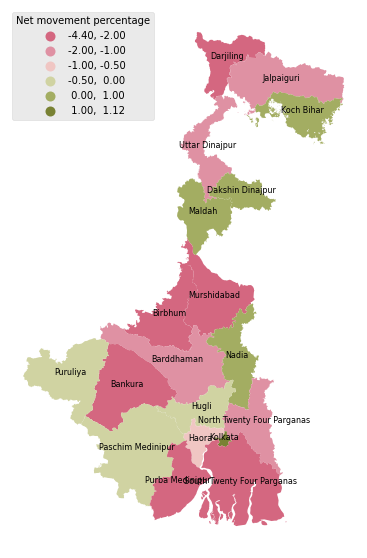

In [34]:
# plot the choropleth map and export it
cmap = ListedColormap(palettable.cartocolors.diverging.ArmyRose_7_r.mpl_colors)

markersize = 15
fontdict = {}
plt.style.use('ggplot')  # these plots use this style

ax = merged.plot(
    column='net_mvmt_pct', 
    legend=True, 
    scheme='UserDefined',
    classification_kwds={'bins': [-2, -1, -0.5, 0, 1]}, 
    legend_kwds={'title': 'Net movement percentage', 'loc': 'upper left'}, 
    cmap=cmap,
    figsize=(10, 10),
)

ax.set_axis_off()

for ind, index in enumerate(merged.index):
    ax.annotate(
        merged.loc[index, 'L2_NAME'], 
        xy=(merged.loc[index, 'Longitude'], merged.loc[index, 'Latitude']), 
        xycoords="data", 
        fontsize='8', 
        horizontalalignment='center'
    )

# plt.savefig('Charts/amphan_veraset_200527.png', dpi=300)

# Daily analysis

## Timeseries plot of number of daily captured devices for cyclone Amphan affected districts

In [35]:
ddf = pd.read_csv('Results/2020/adm2/Amphan/West_Bengal_Daily_Movement.csv')
ddf['adm2_name'] = ddf['adm2'].map(dict(zip(adm2['L2_CODE'], adm2['L2_NAME'])))

ddf['Date'] = pd.to_datetime(ddf['Date'], format='%Y_%m_%d')

In [36]:
adm2_popn = pd.read_csv('adm2_popn_2011.csv')
wb_popn = adm2_popn[adm2_popn['State'] == 'West Bengal']

# add population column from the population CSV file
ddf['popn'] = ddf['adm2_name'].map(dict(zip(wb_popn['District'], wb_popn['Population'])))

# convert into devices to population ratio
ddf['pct'] = 1000 * ddf['total'] / ddf['popn']

In [37]:
# we take North Twenty Four Parganas, Kolkata, South Twenty Four Parganas and Purba Medinipur as the cyclone Amphan affected districts
affected_districts = pd.Series(
    ['North Twenty Four Parganas', 'Kolkata', 'South Twenty Four Parganas', 'Purba Medinipur']
)

# names and admin codes of the affected districts
ad_map = {
    'North Twenty Four Parganas': 337,
#     'Kolkata': 342,
    'South Twenty Four Parganas': 343,
    'Purba Medinipur': 345,
}

# compute mean metrics of those affected districts 
mean_ad_df = pd.DataFrame(ddf[ddf['adm2'] != 342].groupby(['Date']).mean()['total']).reset_index()

traces = []
    
for district, code in ad_map.items():
    df_nmp = ddf[ddf['adm2'] == code]
    traces.append(
        go.Scatter(
            opacity=0.15, 
            x=df_nmp['Date'], 
            y=df_nmp['total'], 
            name=district,
        )
    )

traces.append(
    go.Scatter(
        opacity=1, 
        x=mean_ad_df['Date'], 
        y=mean_ad_df['total'], 
        name='Districts average'
    )
)

traces.extend([
    go.Scatter(
        x=[datetime(2020, 5, 21), datetime(2020, 5, 21)],
        y=[0, 20000],
        line={
            'dash': 'dashdot',
        },
    ),
    go.Scatter(
        x=[datetime(2020, 5, 21)],
        y=[21000],
        mode="text",
        text=["Amphan made landfall in West Bengal"],
        textposition="bottom center",
        name=None
    ),
])



# Using plotly.express
fig = go.Figure()
fig.add_traces(traces)

for trace in fig['data']:
    if trace['name'] not in  {'North Twenty Four Parganas', 'South Twenty Four Parganas', 'Purba Medinipur', 'Districts average'}:
        trace['showlegend'] = False
        
fig.update_layout(
    title="Daily devices captured for Amphan affected districts (except Kolkata)",
    xaxis_title="Date",
    yaxis_title="Number of devices",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.75
    ),
    autosize=False,
    width=1000,
    height=550,
)

# fig.write_image("Charts/daily_devices_amphan_affected_districts.png", scale=15)

fig.show()

In [38]:
# we take North Twenty Four Parganas, Kolkata, South Twenty Four Parganas and Purba Medinipur as the cyclone Amphan affected districts
affected_districts = pd.Series(
    ['Purba Midnipur', 'Paschim Medinipur', 'South Twenty Four Parganas', 
     'North Twenty Four Parganas', 'Haora', 'Hugli', 'Kolkata',
     'Burdwan', 'Murshidabad']
)
# Source: https://www.unicef.org/media/82101/file/India-West-Bengal-Cyclone-Amphan-SitRep-22-May-2020.pdf

# names and admin codes of the affected districts
ad_map = dict(ddf[ddf['adm2_name'].isin(affected_districts)][['adm2_name', 'adm2']].drop_duplicates().values)
nad_map = dict(ddf[~ddf['adm2_name'].isin(affected_districts)][['adm2_name', 'adm2']].drop_duplicates().values)

# compute mean metrics of those affected districts 
mean_ad_df = pd.DataFrame(ddf[ddf['adm2_name'].isin(affected_districts)].groupby(['Date']).mean()['pct']).reset_index()
mean_nad_df = pd.DataFrame(ddf[~ddf['adm2_name'].isin(affected_districts)].groupby(['Date']).mean()['pct']).reset_index()

traces = []
    
for district, code in ad_map.items():
    if code == 342:
        continue
    df_nmp = ddf[ddf['adm2'] == code]
    traces.append(
        go.Scatter(
            opacity=0.1, 
            x=df_nmp['Date'], 
            y=df_nmp['pct'], 
            name=district,
            line={
                'color': 'red'
            }
        )
    )

for district, code in nad_map.items():
    df_nmp = ddf[ddf['adm2'] == code]
    traces.append(
        go.Scatter(
            opacity=0.1, 
            x=df_nmp['Date'], 
            y=df_nmp['pct'], 
            name=district,
            line={
                'color': 'green'
            }
        )
    )
    
traces.append(
    go.Scatter(
        opacity=1, 
        x=mean_ad_df['Date'], 
        y=mean_ad_df['pct'], 
        name='Affected districts average',
        line={
            'color': 'red'
        }
    )
)

traces.append(
    go.Scatter(
        opacity=1, 
        x=mean_nad_df['Date'], 
        y=mean_nad_df['pct'], 
        name='Non-affected districts average',
        line={
            'color': 'green'
        }
    )
)

traces.extend([
    go.Scatter(
        x=[datetime(2020, 5, 20), datetime(2020, 5, 20)],
        y=[0, 3.75],
        line={
            'dash': 'dashdot',
        },
    ),
    go.Scatter(
        x=[datetime(2020, 5, 19)],
        y=[4],
        mode="text",
        text=["Amphan made landfall in West Bengal"],
        textposition="bottom center",
        name=None
    ),
])



# Using plotly.express
fig = go.Figure()
fig.add_traces(traces)

for trace in fig['data']:
    if trace['name'] not in  {'Affected districts average', 'Non-affected districts average'}:
        trace['showlegend'] = False
        
fig.update_layout(
    title="",
    xaxis_title="Date",
    yaxis_title="Devices captured per 1,000 people",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.75
    ),
    autosize=False,
    width=1000,
    height=550,
)

fig.write_image("Charts/devices_pct_amphan_districts.png", scale=15)

fig.show()

In [39]:
print("Affected districts:", round(100 * (3.5 - 2.04) / 3.5), '%')
print("Non-affected districts:", round(100 * (1 - 0.71) / 1), '%')

Affected districts: 42 %
Non-affected districts: 29 %


## Net movement percentage

In [40]:
ddf['net_mvmt_pct'] = 100 * ddf['net_mvmt_pct']

# we take North Twenty Four Parganas, Kolkata, South Twenty Four Parganas and Purba Medinipur as the cyclone Amphan affected districts
affected_districts = pd.Series(
    ['North Twenty Four Parganas', 'Kolkata', 'South Twenty Four Parganas', 'Purba Medinipur', 'Bankura']
)

# names and admin codes of the affected districts
ad_map = {
    'North Twenty Four Parganas': 337,
    'Kolkata': 342,
    'South Twenty Four Parganas': 343,
    'Purba Medinipur': 345,
    'Bankura': 339,
}

# compute mean metrics of those affected districts 
mean_ad_df = pd.DataFrame(ddf.groupby(['Date']).mean()['net_mvmt_pct']).reset_index()

traces = []
    
for district, code in ad_map.items():
    df_t = ddf[ddf['adm2'] == code]
    traces.append(
        go.Scatter(
            opacity=1, 
            x=df_t['Date'], 
            y=df_t['net_mvmt_pct'], 
            name=district,
        )
    )

# traces.append(
#     go.Scatter(
#         opacity=1, 
#         x=mean_ad_df['Date'], 
#         y=mean_ad_df['net_mvmt_pct'], 
#         name='Districts average'
#     )
# )

traces.extend([
    go.Scatter(
        x=[datetime(2020, 5, 21), datetime(2020, 5, 21)],
        y=[-3, 4],
        line={
            'dash': 'dashdot',
        },
        name='Amphan made landfall in West Bengal',
    ),
    go.Scatter(
        x=[datetime(2020, 5, 21)],
        y=[4.5],
        mode="text",
        text=["Amphan made landfall in West Bengal"],
        textposition="bottom center",
        name=None
    ),
])

# Using plotly.express
fig = go.Figure()
fig.add_traces(traces)

for trace in fig['data']:
    if trace['name'] in  {None, 'Amphan made landfall in West Bengal'}:
        trace['showlegend'] = False
        
fig.update_layout(
    title="",
    xaxis_title="Date",
    yaxis_title="Net movement percentage (%)",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    autosize=False,
    width=1000,
    height=550,
)

fig.write_image("Charts/nmp_amphan_affected_districts.png", scale=15)

fig.show()